In [ ]:
pip install ipdb

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.ndimage import correlate
from scipy.ndimage import convolve
import torch 
import cvxpy as cp
import scipy as sp
import scipy.sparse.linalg
from scipy.linalg import circulant
from numpy.linalg import matrix_power
from scipy import ndimage, misc
import ipdb
import warnings
import time
from google.colab import files
warnings.filterwarnings("ignore")

In [ ]:
#Split Bregman for solving min_x ||D_1x||_1 + ||D_2x||_1 + \epsilon*||y-Ax||^2   st. x>=0  (may not have this constrain)
#here A=F\SigmaF^H
#this function can be used to solve (7) for 1D TV sparse signal
def myADMM(Sigma,y,constrain=False,maxit=3000,tol=1e-6,epsilon=1e-1,rho=1):
  #the choice of rho must be careful!
  N = len(y)
  D1 = sp.sparse.diags(np.ones((N,)),0) -sp.sparse.diags(np.ones((N-1,)),-1)
  D1[0,-1] = -1
  D2 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-n,)),n) - sp.sparse.diags(np.ones((n,)),n-N) 
  y = y.reshape(N,)
  err = []
  loss = []
  a = np.zeros(N,)
  a[0] = 1
  a[-1] = -1
  Lambda1 = sp.sparse.diags(scipy.fft.fft(a),0) #eigenvector of D1
  Lambda2 = sp.sparse.diags(scipy.fft.fft(D2[0,:].toarray().reshape(N,)),0)
  x = y#np.random.randn(N,)
  dx = np.zeros(N,)#np.random.randn(N,)
  dy = np.zeros(N,)#np.random.randn(N,)
  bx = np.zeros(N,)#np.random.randn(N,)
  by = np.zeros(N,)#np.random.randn(N,)
  Fy = sp.fft.fft(y).conjugate()
  d = (2*epsilon*Sigma**2+rho*Lambda1.conjugate()@Lambda1+rho*Lambda2.conjugate()@Lambda2).diagonal()
  invD = sp.sparse.diags(1/d,0)
  #ipdb.set_trace()
  if constrain == True:
    for i in range(maxit):
      x = np.real(sp.fft.fft(invD@(2*epsilon*Sigma@Fy+rho*Lambda1.conjugate()@sp.fft.fft(dx-bx).conjugate()+rho*Lambda2.conjugate()@sp.fft.fft(dy-by).conjugate())))/N
      x = np.maximum(x,0)
      loss.append(np.linalg.norm(D1@x,1)+epsilon*np.linalg.norm(y-sp.fft.fft(Sigma@sp.fft.fft(x).conjugate())/N)**2)
      dx = (abs(D1@x+bx)>(1./rho))*(abs(D1@x+bx)-1./rho)*np.sign(D1@x+bx)
      dy = (abs(D2@x+by)>(1./rho))*(abs(D2@x+by)-1./rho)*np.sign(D2@x+by)
      bx = bx + D1@x - dx
      by = by + D2@x - dy
      err.append(np.linalg.norm(D1@x-dx)+np.linalg.norm(D2@x-dy))
      if i>50 and np.linalg.norm(D1@x-dx)+np.linalg.norm(D2@x-dy) < tol:
        print('iter',i)
        break
      #if np.mod(i,1000) == 0:
      #  print(i)
  else: 
    for i in range(maxit):
      x = np.real(sp.fft.fft(invD@(2*epsilon*Sigma@Fy+rho*Lambda1.conjugate()@sp.fft.fft(dx-bx).conjugate()+rho*Lambda2.conjugate()@sp.fft.fft(dy-by).conjugate())))/N
      loss.append(np.linalg.norm(D1@x,1)+epsilon*np.linalg.norm(y-sp.fft.fft(Sigma@sp.fft.fft(x).conjugate())/N)**2)
      dx = (abs(D1@x+bx)>(1./rho))*(abs(D1@x+bx)-1./rho)*np.sign(D1@x+bx)
      dy = (abs(D2@x+by)>(1./rho))*(abs(D2@x+by)-1./rho)*np.sign(D2@x+by)
      bx = bx + D1@x - dx
      by = by + D2@x - dy
      err.append(np.linalg.norm(D1@x-dx)+np.linalg.norm(D2@x-dy))
      if i>50 and np.linalg.norm(D1@x-dx)+np.linalg.norm(D2@x-dy) < tol:
        print('iter',i)
        break
  return x,err,loss
def l1solv(Fw1,meas,constraint=True,epsilon=1e0):
# Create variable.
   N = len(meas)
   D1 = sp.sparse.diags(np.ones((N,)),0) -sp.sparse.diags(np.ones((N-1,)),-1)
   D1[0,-1] = -1
   x_l1 = cp.Variable(shape=(N,1))
   constraints = [x_l1>=0] #, cp.norm(Fw1.numpy()@x_l1-meas, 2)<=torch.norm(noise)]
# Form objective.
   obj = cp.Minimize(cp.norm(D1@x_l1, 1) + epsilon*cp.norm((Fw1@x_l1)-meas, 2)**2)
# Form and solve problem.
   if constraint == False:
    prob = cp.Problem(obj)
   else:
     prob = cp.Problem(obj, constraints)
   prob.solve()
   x2 = torch.from_numpy(x_l1.value[:,0]).cpu().type(dtype=torch.float32)
   #plt.plot(x_l1.value,'y')
   #plt.plot(u,'c')
   #plt.plot(meas,'r')
   mx_norm = torch.norm(torch.from_numpy(D1@x_l1.value[:,0]), 0.5)**0.5+(torch.norm(torch.from_numpy(D1@x_l1.value[:,0]), 2))**2*1e-4
   #psnr_recon = psnr2(u,x_l1.value.T)
   #print('psnr:{:f}, mixednorm:{:f}'.format(psnr_recon,mx_norm))
   return x_l1.value
def psnr1(A,B):
  MSE = torch.mean((A-B)**2)**0.5
  return 20*np.log(torch.max(torch.abs(A))/MSE)/np.log(10)
def psnr2(A,B):
  MSE = np.mean((A-B)**2)**0.5
  return 20*np.log(np.amax(abs(A))/MSE)/np.log(10)
def makeA2d(n=10,alpha=20):
    s = 1/(2*alpha)
    N = n**2
    A = (1-4*s)*sp.sparse.diags(np.ones((N,)),0) + s*sp.sparse.diags(np.ones((N-1,)),-1) + s*sp.sparse.diags(np.ones((N-1,)),1) \
        + s*sp.sparse.diags(np.ones((N-n,)),n) + s*sp.sparse.diags(np.ones((N-n,)),-n) + s*sp.sparse.diags(np.ones((n,)),N-n) + s*sp.sparse.diags(np.ones((n,)),n-N)
    A[0,-1] = s
    A[-1,0] = s
    return A
def inside_ellipse(N, theta, ax1, ax2):
    """
    returns a boolean image marking the pixels inside the given ellipse
    """
    x, y = torch.meshgrid(torch.linspace(-1, 1, N), torch.linspace(-1, 1, N))
    x_rot = torch.cos(theta)*x + torch.sin(theta)*y
    y_rot = -torch.sin(theta)*x + torch.cos(theta)*y
    return x_rot**2 / ax1**2 + y_rot**2 / ax2**2 < 1

def make_im(N, thetas, ax1s, ax2s):
  
    im = torch.zeros(N,N)  

    for ax1, ax2, theta in zip(ax1s, ax2s, thetas):
        im[inside_ellipse(N, theta, ax1, ax2)] += 1
    im = im/im.max()
    return im
def pyramid(n):
    r = np.arange(n)
    d = np.minimum(r,r[::-1])
    return np.minimum.outer(d,d)

In [ ]:
# define the image size and the parameters of the ellipses, as well as the filters for measurements
def get_ellipse(n=256,alpha=20,Ncount=1000,filter='Gaussian'):
  N = n**2
  ax1s = [0.2, 0.5]  # solution (anything else is fine)
  ax2s = [0.9, 0.7]  # solution
  thetas = torch.tensor([0.4*math.pi, 0.4*math.pi])  # solution
  im = make_im(n, thetas, ax1s, ax2s).numpy().reshape(n,n).T  # ground truth image
  imres=im.reshape(N,)
  A2d=makeA2d(n,alpha)
  Sigma = sp.sparse.diags(np.real(scipy.fft.fft(A2d[0,:].toarray().reshape(N,))))
  if filter == 'Gaussian':
    mres = np.real(sp.fft.fft((Sigma**Ncount@sp.fft.fft(imres).conjugate()).reshape(N,))/N)
    meas = mres.reshape(n,n)
  elif filter == 'average':
    meas = ndimage.uniform_filter(im, size=20)
  elif filter == 'maximum':
    meas = ndimage.maximum_filter(im,size=20)
  elif filter == 'pyramid':
    size = 20
    P = pyramid(size)
    P = P/np.sum(P)
    meas = convolve(im,P)#correlate(im,P)
  elif filter == 'miscellaneous':
    size = 20
    P = pyramid(size)**0.5
    P = P/np.sum(P)
    meas = convolve(im,P)#correlate(im,P)
  elif filter == 'Gaussian_local':
    x1, y1 = np.meshgrid(np.linspace(-1,1,20), np.linspace(-1,1,20))
    dst = np.sqrt((x1*x1+y1*y1))
    sigma = 0.5
    muu = 0.000
    gauss = np.exp(-( (dst-muu)**2 / ( 2.0 * sigma**2 ) ) )
    gauss = gauss/np.sum(gauss)
    meas = convolve(im,gauss)#correlate(im,gauss)
  return im,meas,Sigma

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc16beaae10>,
 <matplotlib.image.AxesImage at 0x7fc16bd887d0>)

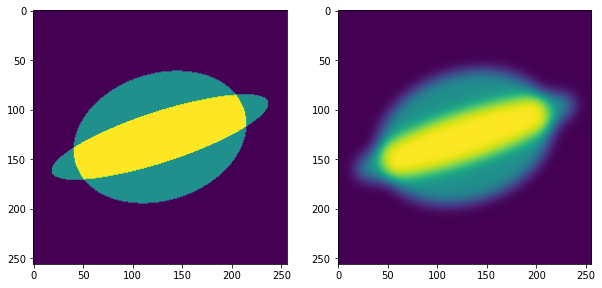

In [ ]:
n = 256
N = n**2
Ncount = 1000
im,meas,Sigma = get_ellipse(n,Ncount=Ncount)
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(im)
plt.subplot(122),plt.imshow(meas)

In [ ]:
t = np.linspace(500,2000,20)
a =[]
b =[]
D1 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-1,)),-1)
D1[0,-1] = -1
D2 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-n,)),n) - sp.sparse.diags(np.ones((n,)),n-N) 
for ti in range(20):
    #u_rec = l1solv(np.linalg.matrix_power(A.toarray(),int(t[ti])),meas1,constraint=False,epsilon=1e-1)
    u_rec,err,loss = myADMM(Sigma**(int(t[ti])),meas.reshape(N,),constrain=True,rho=1,maxit=300,epsilon=1e7)
    #mix_norm = (np.linalg.norm(D1@(u_rec).reshape(N,), 0.5)+np.linalg.norm(D2@(u_rec).reshape(N,), 0.5))**0.5 + 1e-4*(np.linalg.norm(D1@(u_rec).reshape(N,), 2))**2
    mix_norm = (np.linalg.norm(D1@(u_rec).reshape(N,), 0.5)**0.5+np.linalg.norm(D2@(u_rec).reshape(N,), 0.5))**0.5 + 1e-4*(np.linalg.norm(D1@(u_rec).reshape(N,), 2))**2 \
               + 1e-4*(np.linalg.norm(D2@(u_rec).reshape(N,), 2))**2
    psnr_rec = psnr2(im.reshape(N,),u_rec)
    a.append(mix_norm)
    b.append(psnr_rec)
    print('N:',t[ti],'psnr',psnr_rec,'mixed norm:',mix_norm)

N: 500.0 psnr 23.732096102269278 mixed norm: 2467.6509384382684
N: 578.9473684210526 psnr 24.357135686021188 mixed norm: 2303.710972245068
N: 657.8947368421052 psnr 24.563177573971764 mixed norm: 2309.7287463099397
N: 736.8421052631579 psnr 23.867055255177494 mixed norm: 2256.8601807403793
N: 815.7894736842105 psnr 23.96269151467748 mixed norm: 1976.8183959949874
N: 894.7368421052631 psnr 25.188095689297665 mixed norm: 1833.9230762645452
N: 973.6842105263158 psnr 35.21193716834517 mixed norm: 1705.662550085405
N: 1052.6315789473683 psnr 31.874445911156325 mixed norm: 1619.7990331967294
N: 1131.578947368421 psnr 27.173290906188384 mixed norm: 2077.228121160814
N: 1210.5263157894738 psnr 23.499671513585163 mixed norm: 2409.1608893500993
N: 1289.4736842105262 psnr 19.97132660779943 mixed norm: 2772.5059243712894
N: 1368.421052631579 psnr 16.988690194571404 mixed norm: 3181.1202808838543
N: 1447.3684210526317 psnr 14.243933317187903 mixed norm: 3573.302186484905
N: 1526.3157894736842 psnr 

([<matplotlib.lines.Line2D at 0x7f76e4598a10>],
 <matplotlib.legend.Legend at 0x7f76e471ea10>)

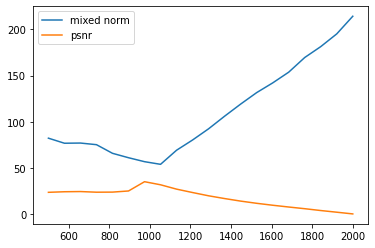

In [ ]:
plt.plot(t,np.array(a)/30)
plt.plot(t,b),plt.legend(['mixed norm','psnr'])

psnr 32.54649777155495


(<matplotlib.axes._subplots.AxesSubplot at 0x7f76e4388890>,
 Text(0.5, 1.0, 'measurement'))

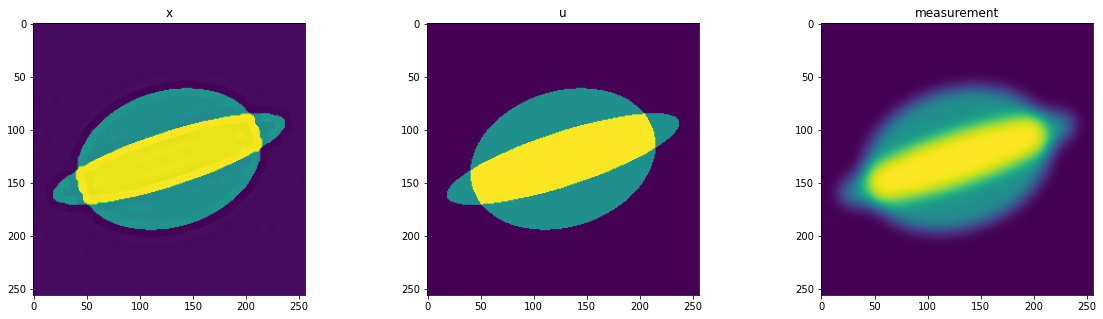

In [ ]:
N_recon = np.round(t[a==np.min(a)])
x,err,loss = myADMM(Sigma**int(N_recon),meas.reshape(N,1),constrain=False,rho=1,maxit=300,epsilon=1e7)
print('psnr',psnr2(x,im.reshape(N,)))
plt.figure(figsize=(20,5))
plt.subplot(131),plt.imshow(x.reshape(n,n)),plt.title('x')
plt.subplot(132),plt.imshow(im),plt.title('u')
#plt.subplot(143),plt.imshow(x_cvx.reshape(n,n)),plt.title('x_cvx')
plt.subplot(133),plt.imshow(meas),plt.title('measurement')

Moving average filter 

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6c7bc9af90>,
 <matplotlib.image.AxesImage at 0x7f6c7b765850>)

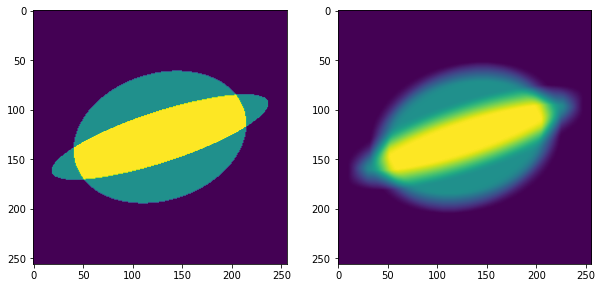

In [ ]:
im1,meas1,Sigma = get_ellipse(filter='average')
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(im1)
plt.subplot(122),plt.imshow(meas1)

In [ ]:
t = np.linspace(800,1500,20)
a1 =[]
b1 =[]
for ti in range(20):
    u1_rec,err,loss = myADMM(Sigma**(int(t[ti])),meas1.reshape(N,),constrain=False,rho=1,maxit=300,epsilon=1e2)
    mix_norm = (np.linalg.norm(D1@(u1_rec).reshape(N,), 0.5)**0.5+np.linalg.norm(D2@(u1_rec).reshape(N,), 0.5))**0.5 + 1e-4*(np.linalg.norm(D1@(u1_rec).reshape(N,), 2))**2 \
               + 1e-4*(np.linalg.norm(D2@(u1_rec).reshape(N,), 2))**2
    psnr_rec = psnr2(im1.reshape(N,),u1_rec)
    a1.append(mix_norm)
    b1.append(psnr_rec)
    print('N:',t[ti],'psnr',psnr_rec,'mixed norm:',mix_norm)

N: 800.0 psnr 23.40125138583319 mixed norm: 1856.154698337264
N: 836.8421052631579 psnr 23.935110018335156 mixed norm: 1855.785560287412
N: 873.6842105263158 psnr 24.472522938695562 mixed norm: 1869.9547673602572
N: 910.5263157894738 psnr 25.032660438711535 mixed norm: 1865.624613325639
N: 947.3684210526316 psnr 25.4258239789398 mixed norm: 1875.7737004890373
N: 984.2105263157895 psnr 25.4963909376361 mixed norm: 1876.421362819784
N: 1021.0526315789474 psnr 25.24634261508448 mixed norm: 1876.3902397336792
N: 1057.8947368421052 psnr 24.892775145256408 mixed norm: 1902.6626186556173
N: 1094.7368421052631 psnr 24.415869929537827 mixed norm: 1892.869810640613
N: 1131.578947368421 psnr 24.06043080111685 mixed norm: 1904.0504526374732
N: 1168.421052631579 psnr 23.723887319124188 mixed norm: 1936.165362858573
N: 1205.2631578947369 psnr 23.391799511004166 mixed norm: 1956.2754271527635
N: 1242.1052631578948 psnr 23.079352311495665 mixed norm: 1963.5241018701101
N: 1278.9473684210527 psnr 22.78

([<matplotlib.lines.Line2D at 0x7f76eb8f2cd0>],
 <matplotlib.legend.Legend at 0x7f76eb944790>)

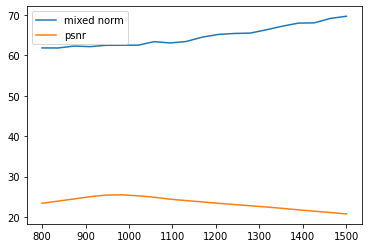

In [ ]:
plt.plot(t,np.array(a1)/30)
plt.plot(t,b1),plt.legend(['mixed norm','psnr'])

psnr of reconstruction 23.949460308298935
psnr of measurement 22.316003391039445


(<matplotlib.axes._subplots.AxesSubplot at 0x7f76eb817f90>,
 Text(0.5, 1.0, 'measurement'))

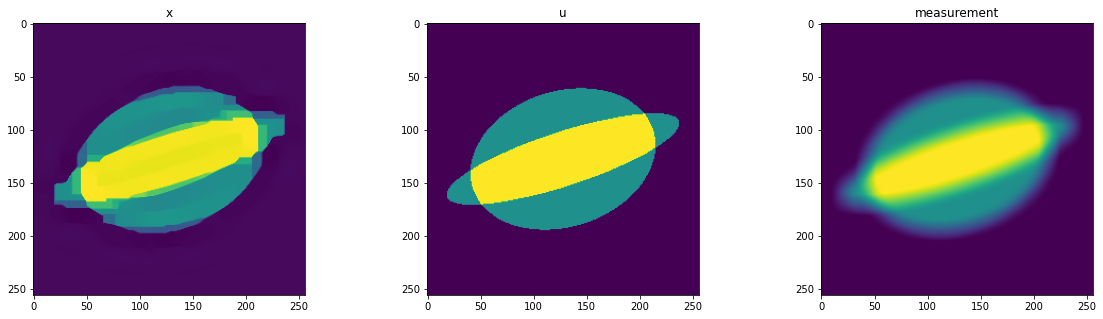

In [ ]:
N_recon = np.round(t[a1==np.min(a1)])
x1,err,loss = myADMM(Sigma**int(N_recon),meas1.reshape(N,1),constrain=False,rho=1,maxit=300,epsilon=1e2)
print('psnr of reconstruction',psnr2(im1.reshape(N,),x1))
print('psnr of measurement',psnr2(im1.reshape(N,),meas1.reshape(N,)))
plt.figure(figsize=(20,5))
plt.subplot(131),plt.imshow(x1.reshape(n,n)),plt.title('x')
plt.subplot(132),plt.imshow(im),plt.title('u')
plt.subplot(133),plt.imshow(meas1),plt.title('measurement')

Maximum filter (indeed, there's no diffusion for the maximum filter, it makes sense that the method doesn't work for this case)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6c7b6d8b90>,
 <matplotlib.image.AxesImage at 0x7f6c7b6b0e50>)

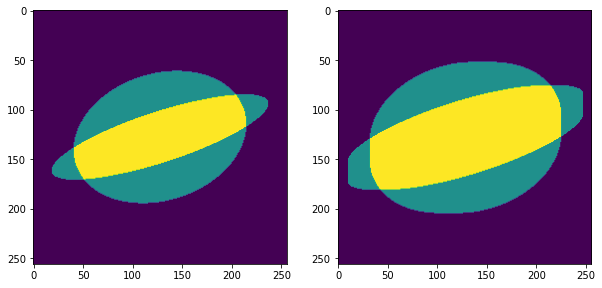

In [ ]:
im2,meas2,Sigma = get_ellipse(filter='maximum')
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(im2)
plt.subplot(122),plt.imshow(meas2)

In [ ]:
t = np.linspace(8,1500,20)
a2 =[]
b2 =[]
for ti in range(20):
    u2_rec,err,loss = myADMM(Sigma**(int(t[ti])),meas2.reshape(N,),constrain=False,rho=1,maxit=300,epsilon=1e0)
    mix_norm = (np.linalg.norm(D1@(u2_rec).reshape(N,), 0.5)**0.5+np.linalg.norm(D2@(u2_rec).reshape(N,), 0.5))**0.5 + 1e-4*(np.linalg.norm(D1@(u2_rec).reshape(N,), 2))**2 \
               + 1e-4*(np.linalg.norm(D2@(u2_rec).reshape(N,), 2))**2
    psnr_rec = psnr2(im2.reshape(N,),u2_rec)
    a2.append(mix_norm)
    b2.append(psnr_rec)
    print('N:',t[ti],'psnr',psnr_rec,'mixed norm:',mix_norm)

N: 8.0 psnr 13.173134105865143 mixed norm: 1808.1213041842107
N: 86.52631578947368 psnr 13.112038228008734 mixed norm: 1679.9059711495513
N: 165.05263157894737 psnr 13.068824587200451 mixed norm: 1613.2958135452195
N: 243.57894736842104 psnr 13.024416298174907 mixed norm: 1557.1289921594353
N: 322.10526315789474 psnr 12.98347622010792 mixed norm: 1491.9807158083036
N: 400.63157894736844 psnr 12.950311685631464 mixed norm: 1447.3307907119736
N: 479.1578947368421 psnr 12.917563471088402 mixed norm: 1400.3003384733568
N: 557.6842105263158 psnr 12.893418267890393 mixed norm: 1385.243491952261
N: 636.2105263157895 psnr 12.86547574615215 mixed norm: 1349.638394065536
N: 714.7368421052631 psnr 12.840968812135586 mixed norm: 1328.8284732824636
N: 793.2631578947369 psnr 12.82132863430408 mixed norm: 1320.1206711780644
N: 871.7894736842105 psnr 12.806781184882233 mixed norm: 1316.7318761959032
N: 950.3157894736842 psnr 12.791152383182649 mixed norm: 1298.0340870481455
N: 1028.842105263158 psnr 1

([<matplotlib.lines.Line2D at 0x7f76eb6a3c10>],
 <matplotlib.legend.Legend at 0x7f76eb8403d0>)

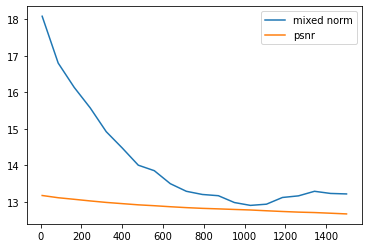

In [ ]:
plt.plot(t,np.array(a2)/100)
plt.plot(t,b2),plt.legend(['mixed norm','psnr'])

psnr of reconstruction 13.169086090870353
psnr of measurement 12.823268564386366


(<matplotlib.axes._subplots.AxesSubplot at 0x7f76eb591ad0>,
 Text(0.5, 1.0, 'measurement'))

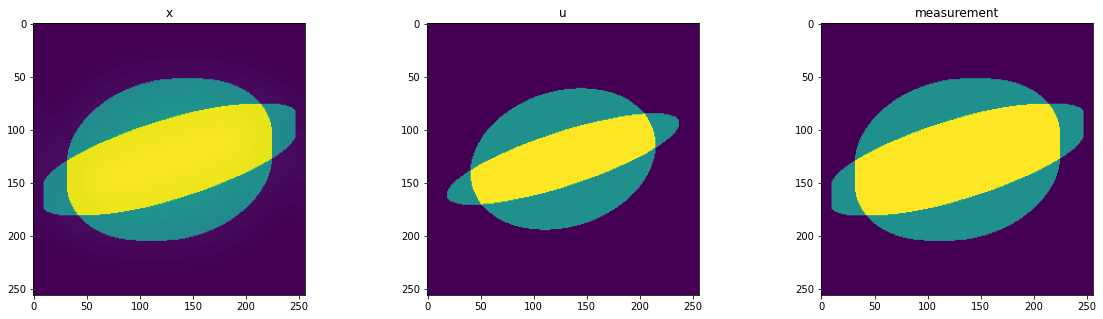

In [ ]:
N_recon = 10#np.round(t[a==np.min(a)])
x2,err,loss = myADMM(Sigma**int(N_recon),meas2.reshape(N,1),constrain=False,rho=1,maxit=300,epsilon=1e0)
#x2 = np.minimum(x2,1)
print('psnr of reconstruction',psnr2(im2.reshape(N,),x2))
print('psnr of measurement',psnr2(im2.reshape(N,),meas2.reshape(N,)))
plt.figure(figsize=(20,5))
plt.subplot(131),plt.imshow(x2.reshape(n,n),vmax=1),plt.title('x')
plt.subplot(132),plt.imshow(im,vmax=1),plt.title('u')
plt.subplot(133),plt.imshow(meas2,vmax=1),plt.title('measurement')

Pyramid filter


(<matplotlib.axes._subplots.AxesSubplot at 0x7fc16bd5a150>,
 <matplotlib.image.AxesImage at 0x7fc16b834990>)

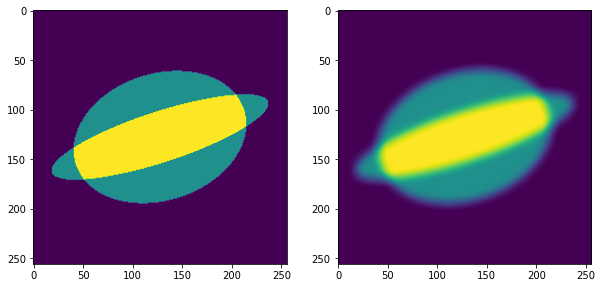

In [ ]:
im3,meas3,Sigma = get_ellipse(filter='pyramid')
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(im3)
plt.subplot(122),plt.imshow(meas3)

In [ ]:
t = np.linspace(100,1000,20)
a3 =[]
b3 =[]
D1 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-1,)),-1)
D1[0,-1] = -1
D2 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-n,)),n) - sp.sparse.diags(np.ones((n,)),n-N) 
for ti in range(20):
    u3_rec,err,loss = myADMM(Sigma**(int(t[ti])),meas3.reshape(N,),constrain=True,rho=1,maxit=300,epsilon=1e2)
    mix_norm = (np.linalg.norm(D1@(u3_rec).reshape(N,), 0.5)**0.5+np.linalg.norm(D2@(u3_rec).reshape(N,), 0.5))**0.5 + 5e-4*(np.linalg.norm(D1@(u3_rec).reshape(N,), 2))**2 \
               + 5e-4*(np.linalg.norm(D2@(u3_rec).reshape(N,), 2))**2
    #mix_norm = np.linalg.norm(((D1@(u3_rec)).reshape(N,)**2+(D2@(u3_rec)).reshape(N,)**2)**0.5,0.5)**0.5 + 1e-4*(np.linalg.norm(D1@(u3_rec).reshape(N,), 2))**2 \
    #           + 1e-4*(np.linalg.norm(D2@(u3_rec).reshape(N,), 2))**2
    psnr_rec = psnr2(im3.reshape(N,),u3_rec)
    a3.append(mix_norm)
    b3.append(psnr_rec)
    print('N:',t[ti],'psnr',psnr_rec,'mixed norm:',mix_norm)

N: 100.0 psnr 24.453542474210394 mixed norm: 1966.6809018302326
N: 147.3684210526316 psnr 24.180800284655348 mixed norm: 1887.5736857826196
N: 194.73684210526318 psnr 23.44799123143025 mixed norm: 1628.587410487719
N: 242.10526315789474 psnr 23.65410100967445 mixed norm: 1523.7391421653201
N: 289.47368421052636 psnr 24.37385806345351 mixed norm: 1526.6258729066533
N: 336.8421052631579 psnr 25.358936210520397 mixed norm: 1522.7315231976058
N: 384.2105263157895 psnr 26.625139060146058 mixed norm: 1494.2883478394049
N: 431.5789473684211 psnr 27.013022800738796 mixed norm: 1285.2751925841678
N: 478.94736842105266 psnr 26.65793908629589 mixed norm: 1295.0715110525725
N: 526.3157894736842 psnr 26.1898392048664 mixed norm: 1380.9949915152968
N: 573.6842105263158 psnr 25.680797298514065 mixed norm: 1450.3260647359464
N: 621.0526315789474 psnr 25.13521034510309 mixed norm: 1493.2485046019715
N: 668.421052631579 psnr 24.55011709405481 mixed norm: 1549.0643698384529
N: 715.7894736842105 psnr 24.0

([<matplotlib.lines.Line2D at 0x7f76e418ddd0>],
 <matplotlib.legend.Legend at 0x7f76e41e0090>)

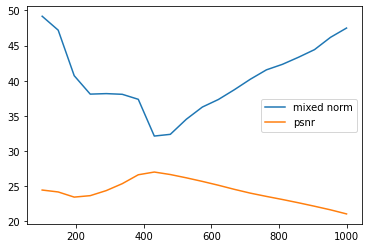

In [ ]:
plt.plot(t,np.array(a3)/40)
plt.plot(t,b3),plt.legend(['mixed norm','psnr'])

psnr of reconstruction 26.991601256123605
psnr of measurement 23.97272875295428


(<matplotlib.axes._subplots.AxesSubplot at 0x7fcff9367250>,
 Text(0.5, 1.0, 'error map'))

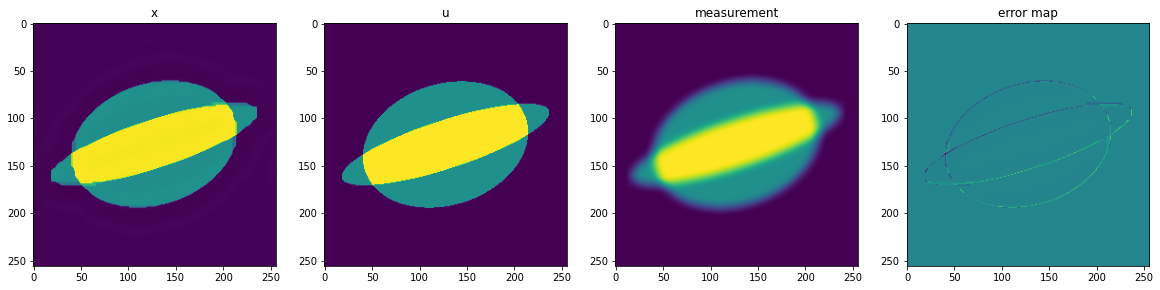

In [ ]:
N_recon = 431#np.round(t[a3==np.min(a3)])
x3,err,loss = myADMM(Sigma**int(N_recon),meas3.reshape(N,1),constrain=False,rho=1,maxit=300,epsilon=1e2)
#x2 = np.minimum(x2,1)
print('psnr of reconstruction',psnr2(im3.reshape(N,),x3))
print('psnr of measurement',psnr2(im3.reshape(N,),meas3.reshape(N,)))
plt.figure(figsize=(20,5))
plt.subplot(141),plt.imshow(x3.reshape(n,n)),plt.title('x')
plt.subplot(142),plt.imshow(im3,vmax=1),plt.title('u')
plt.subplot(143),plt.imshow(meas3,vmax=1),plt.title('measurement')
plt.subplot(144),plt.imshow(im3-x3.reshape(n,n),vmax=1),plt.title('error map')

Gaussian kernel 20*20

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc162e68fd0>,
 <matplotlib.image.AxesImage at 0x7fc162de1710>)

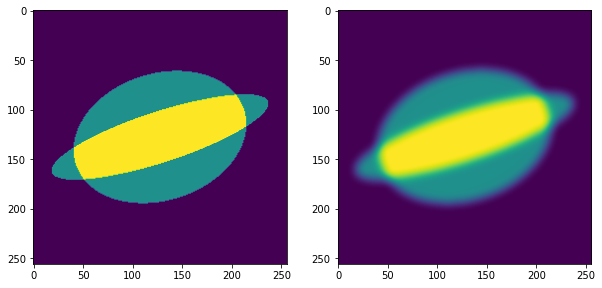

In [ ]:
im4,meas4,Sigma = get_ellipse(filter='Gaussian_local')
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(im4)
plt.subplot(122),plt.imshow(meas4,vmax=1)

In [ ]:
t = np.linspace(100,1000,20)
a4 =[]
b4 =[]
D1 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-1,)),-1)
D1[0,-1] = -1
D2 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-n,)),n) - sp.sparse.diags(np.ones((n,)),n-N) 
for ti in range(20):
    u4_rec,err,loss = myADMM(Sigma**(int(t[ti])),meas4.reshape(N,),constrain=True,rho=1,maxit=300,epsilon=1e2)
    mix_norm = (np.linalg.norm(D1@(u4_rec).reshape(N,), 0.5)**0.5+np.linalg.norm(D2@(u4_rec).reshape(N,), 0.5))**0.5 + 5e-4*(np.linalg.norm(D1@(u4_rec).reshape(N,), 2))**2 \
               + 5e-4*(np.linalg.norm(D2@(u4_rec).reshape(N,), 2))**2
    #mix_norm = np.linalg.norm(((D1@(u3_rec)).reshape(N,)**2+(D2@(u3_rec)).reshape(N,)**2)**0.5,0.5)**0.5 + 1e-4*(np.linalg.norm(D1@(u3_rec).reshape(N,), 2))**2 \
    #           + 1e-4*(np.linalg.norm(D2@(u3_rec).reshape(N,), 2))**2
    psnr_rec = psnr2(im4.reshape(N,),u4_rec)
    a4.append(mix_norm)
    b4.append(psnr_rec)
    print('N:',t[ti],'psnr',psnr_rec,'mixed norm:',mix_norm)

N: 100.0 psnr 24.598525804854795 mixed norm: 2201.4801693364802
N: 147.3684210526316 psnr 24.619289770945006 mixed norm: 1943.6817573626645
N: 194.73684210526318 psnr 23.647445112681524 mixed norm: 1815.171182748538
N: 242.10526315789474 psnr 23.868661037113696 mixed norm: 1635.4277464468844
N: 289.47368421052636 psnr 24.682246913780673 mixed norm: 1617.3819647830376
N: 336.8421052631579 psnr 26.657016299483814 mixed norm: 1728.6691778312488
N: 384.2105263157895 psnr 27.351117130633547 mixed norm: 1473.0552999966858
N: 431.5789473684211 psnr 27.066637984350443 mixed norm: 1180.568167202193
N: 478.94736842105266 psnr 26.62756823529531 mixed norm: 1262.2404666958912
N: 526.3157894736842 psnr 26.192098331502045 mixed norm: 1368.2359639317544
N: 573.6842105263158 psnr 25.72269931296781 mixed norm: 1426.9779642539393
N: 621.0526315789474 psnr 25.25888598368492 mixed norm: 1491.7248445278244
N: 668.421052631579 psnr 24.65390634383441 mixed norm: 1561.7897834697599
N: 715.7894736842105 psnr 2

psnr of reconstruction 27.066637984350443
psnr of measurement 24.004762666644226


(<matplotlib.axes._subplots.AxesSubplot at 0x7fc162e23150>,
 Text(0.5, 1.0, 'error map'))

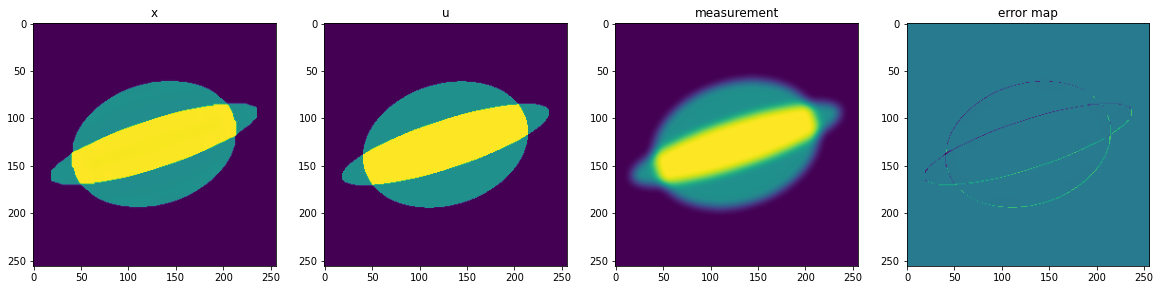

In [ ]:
N_recon = 431#np.round(t[a4==np.min(a4)])
x4,err,loss = myADMM(Sigma**int(N_recon),meas4.reshape(N,1),constrain=True,rho=1,maxit=300,epsilon=1e2)
#x2 = np.minimum(x2,1)
print('psnr of reconstruction',psnr2(im4.reshape(N,),x4))
print('psnr of measurement',psnr2(im4.reshape(N,),meas4.reshape(N,)))
plt.figure(figsize=(20,5))
plt.subplot(141),plt.imshow(x4.reshape(n,n)),plt.title('x')
plt.subplot(142),plt.imshow(im4,vmax=1),plt.title('u')
plt.subplot(143),plt.imshow(meas4),plt.title('measurement')
plt.subplot(144),plt.imshow(im4-x4.reshape(n,n),vmax=1),plt.title('error map')

miscellaneous

(<matplotlib.axes._subplots.AxesSubplot at 0x7fcffbf17ed0>,
 <matplotlib.image.AxesImage at 0x7fcffc81f190>)

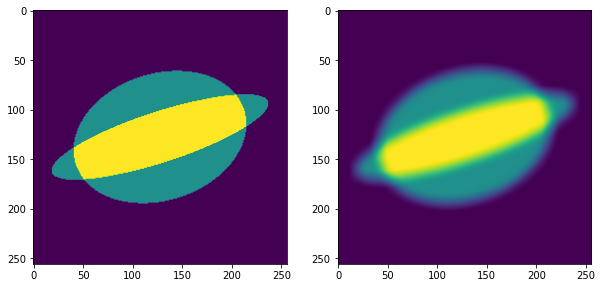

In [ ]:
im5,meas5,Sigma = get_ellipse(filter='miscellaneous')
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(im5)
plt.subplot(122),plt.imshow(meas5,vmax=1)

In [ ]:
t = np.linspace(100,1000,20)
a5 =[]
b5 =[]
D1 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-1,)),-1)
D1[0,-1] = -1
D2 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-n,)),n) - sp.sparse.diags(np.ones((n,)),n-N) 
for ti in range(20):
    u5_rec,err,loss = myADMM(Sigma**(int(t[ti])),meas5.reshape(N,),constrain=True,rho=1,maxit=300,epsilon=1e2)
    mix_norm = (np.linalg.norm(D1@(u5_rec).reshape(N,), 0.5)**0.5+np.linalg.norm(D2@(u5_rec).reshape(N,), 0.5))**0.5 + 1e-4*(np.linalg.norm(D1@(u5_rec).reshape(N,), 2))**2 \
               + 1e-4*(np.linalg.norm(D2@(u5_rec).reshape(N,), 2))**2
    psnr_rec = psnr2(im5.reshape(N,),u5_rec)
    a5.append(mix_norm)
    b5.append(psnr_rec)
    print('N:',t[ti],'psnr',psnr_rec,'mixed norm:',mix_norm)

N: 100.0 psnr 23.532331410382977 mixed norm: 2064.0029727822607
N: 147.3684210526316 psnr 23.515698916505904 mixed norm: 1777.967783879994
N: 194.73684210526318 psnr 22.70268536546567 mixed norm: 1737.4053449379371
N: 242.10526315789474 psnr 22.459904464546028 mixed norm: 1541.5599691006616
N: 289.47368421052636 psnr 22.565069046695875 mixed norm: 1508.185542982349
N: 336.8421052631579 psnr 22.866739191007344 mixed norm: 1527.6625586164407
N: 384.2105263157895 psnr 23.3920237020185 mixed norm: 1541.6235575417652
N: 431.5789473684211 psnr 24.04847121809993 mixed norm: 1538.6970586291004
N: 478.94736842105266 psnr 25.015109527272138 mixed norm: 1561.1858055684577
N: 526.3157894736842 psnr 26.132084667200996 mixed norm: 1490.0215192937037
N: 573.6842105263158 psnr 26.603938736967844 mixed norm: 1382.4829874346656
N: 621.0526315789474 psnr 26.353766325435668 mixed norm: 1402.4014017700329
N: 668.421052631579 psnr 25.834194971462395 mixed norm: 1451.1921086531152
N: 715.7894736842105 psnr 2

psnr of reconstruction 26.607637307255345
psnr of measurement 23.380608790114042


(<matplotlib.axes._subplots.AxesSubplot at 0x7fcffc393ed0>,
 Text(0.5, 1.0, 'error map'))

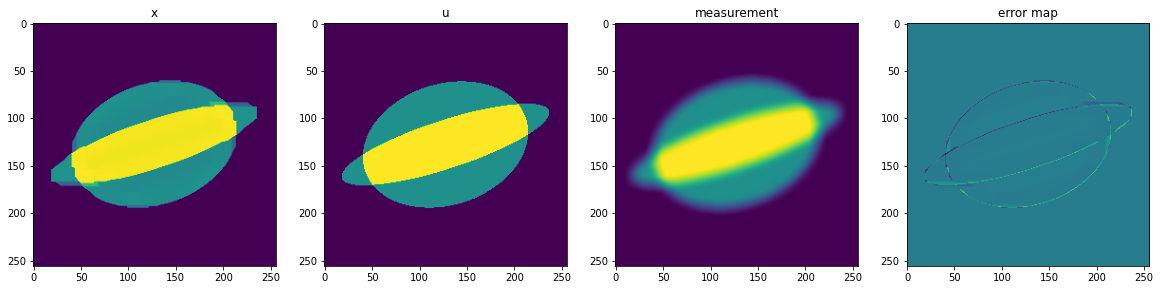

In [ ]:
N_recon = np.round(t[a5==np.min(a5)])
x5,err,loss = myADMM(Sigma**int(N_recon),meas5.reshape(N,1),constrain=True,rho=1,maxit=300,epsilon=1e2)
#x2 = np.minimum(x2,1)
print('psnr of reconstruction',psnr2(im5.reshape(N,),x5))
print('psnr of measurement',psnr2(im5.reshape(N,),meas5.reshape(N,)))
plt.figure(figsize=(20,5))
plt.subplot(141),plt.imshow(x5.reshape(n,n)),plt.title('x')
plt.subplot(142),plt.imshow(im5,vmax=1),plt.title('u')
plt.subplot(143),plt.imshow(meas5),plt.title('measurement')
plt.subplot(144),plt.imshow(im5-x5.reshape(n,n),vmax=1),plt.title('error map')

Hybrid of pyramid and miscellaneous

(<matplotlib.axes._subplots.AxesSubplot at 0x7fcffb3836d0>,
 <matplotlib.image.AxesImage at 0x7fcffb367150>)

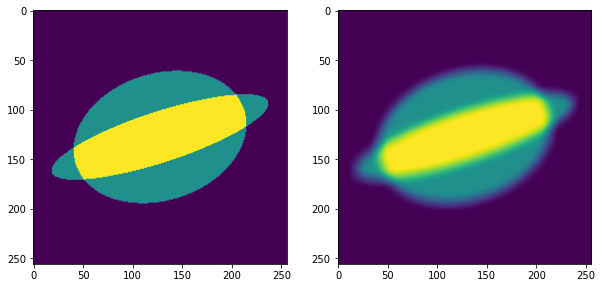

In [ ]:
meas6 = meas3.copy()
meas6[127:,:] = meas5[127:,:].copy()
im6 = im5.copy()
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(im6)
plt.subplot(122),plt.imshow(meas6,vmax=1)

In [ ]:
t = np.linspace(100,1000,20)
a6 =[]
b6 =[]
D1 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-1,)),-1)
D1[0,-1] = -1
D2 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-n,)),n) - sp.sparse.diags(np.ones((n,)),n-N) 
for ti in range(20):
    u6_rec,err,loss = myADMM(Sigma**(int(t[ti])),meas6.reshape(N,),constrain=True,rho=1,maxit=300,epsilon=5e1)
    mix_norm = (np.linalg.norm(D1@(u6_rec).reshape(N,), 0.5)**0.5+np.linalg.norm(D2@(u6_rec).reshape(N,), 0.5))**0.5 + 1e-4*(np.linalg.norm(D1@(u6_rec).reshape(N,), 2))**2 \
               + 1e-4*(np.linalg.norm(D2@(u6_rec).reshape(N,), 2))**2
    psnr_rec = psnr2(im6.reshape(N,),u6_rec)
    a6.append(mix_norm)
    b6.append(psnr_rec)
    print('N:',t[ti],'psnr',psnr_rec,'mixed norm:',mix_norm)

N: 100.0 psnr 24.007813136668403 mixed norm: 1949.9332516601387
N: 147.3684210526316 psnr 23.563718743332757 mixed norm: 1876.4386306786103
N: 194.73684210526318 psnr 22.97689628954186 mixed norm: 1671.5617365747003
N: 242.10526315789474 psnr 23.106711984454304 mixed norm: 1534.619563192731
N: 289.47368421052636 psnr 23.54626559393799 mixed norm: 1507.4113470198215
N: 336.8421052631579 psnr 24.26398005318503 mixed norm: 1506.9708735902104
N: 384.2105263157895 psnr 25.15826128438643 mixed norm: 1490.2390007506226
N: 431.5789473684211 psnr 25.901392891911904 mixed norm: 1373.9517989792232
N: 478.94736842105266 psnr 26.547224781749485 mixed norm: 1383.5819211542425
N: 526.3157894736842 psnr 26.586760506188522 mixed norm: 1345.3250687026982
N: 573.6842105263158 psnr 26.248901208176033 mixed norm: 1349.5002639689544
N: 621.0526315789474 psnr 25.65835790780506 mixed norm: 1362.9678912800578
N: 668.421052631579 psnr 25.173601996737467 mixed norm: 1410.2626244152373
N: 715.7894736842105 psnr 2

psnr of reconstruction 26.586760506188522
psnr of measurement 23.665242869284352


(<matplotlib.axes._subplots.AxesSubplot at 0x7fcff7668a90>,
 Text(0.5, 1.0, 'error map'))

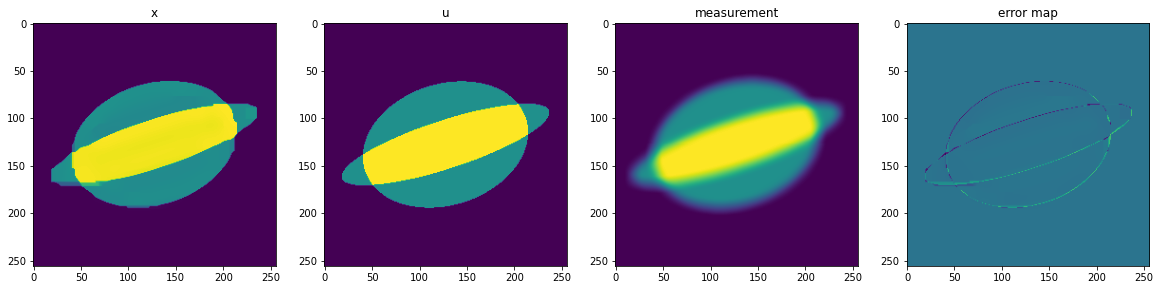

In [ ]:
N_recon = 526#np.round(t[a6==np.min(a6)])
x6,err,loss = myADMM(Sigma**int(N_recon),meas6.reshape(N,1),constrain=True,rho=1,maxit=300,epsilon=5e1)
#x2 = np.minimum(x2,1)
print('psnr of reconstruction',psnr2(im6.reshape(N,),x6))
print('psnr of measurement',psnr2(im6.reshape(N,),meas6.reshape(N,)))
plt.figure(figsize=(20,5))
plt.subplot(141),plt.imshow(x6.reshape(n,n)),plt.title('x')
plt.subplot(142),plt.imshow(im6,vmax=1),plt.title('u')
plt.subplot(143),plt.imshow(meas6),plt.title('measurement')
plt.subplot(144),plt.imshow(im6-x6.reshape(n,n),vmax=1),plt.title('error map')

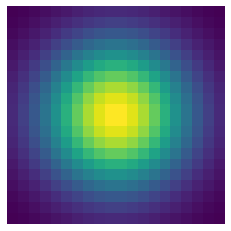

In [ ]:
 ##Creating a Gaussian kernel
# Initializing value of x-axis and y-axis
# in the range -1 to 1
x1, y1 = np.meshgrid(np.linspace(-1,1,20), np.linspace(-1,1,20))
dst = np.sqrt((x1*x1+y1*y1))
  
# Intializing sigma and muu
sigma = 0.5
muu = 0.000
  
# Calculating Gaussian array
gauss = np.exp(-( (dst-muu)**2 / ( 2.0 * sigma**2 ) ) )
gauss = gauss/np.sum(gauss)
plt.imshow(gauss)
plt.axis('off')
plt.show()

P = pyramid(20)
P = P/np.sum(P)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fcffcbfb0d0>,
 [<matplotlib.lines.Line2D at 0x7fcffc763490>])

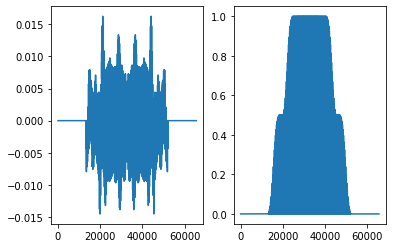

In [ ]:
plt.subplot(121),plt.plot(meas3.reshape(N,)-meas4.reshape(N,))
plt.subplot(122),plt.plot(meas4.reshape(N,))

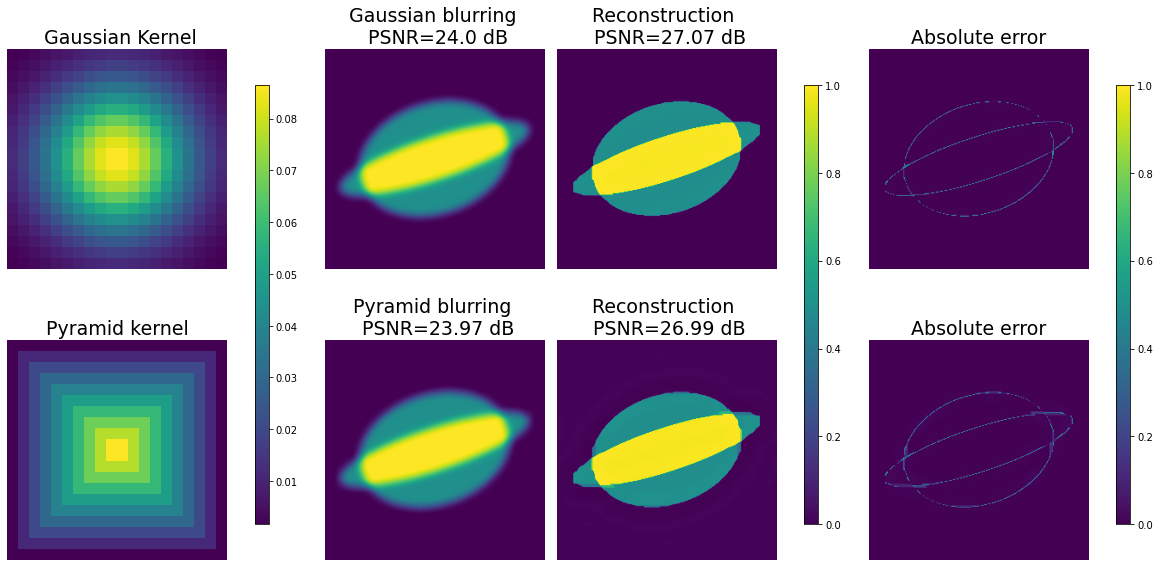

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fig, ax = plt.subplots(2,4,figsize=(16,8), constrained_layout=True)
i0=ax[0,0].imshow(gauss/np.linalg.norm(gauss,1))
ax[0,0].set_ylabel('Gaussian blurring')
ax[0,0].axis('off')

ax[0,0].set_title(' Gaussian Kernel',fontsize=19)
i1=ax[0,1].imshow(meas4,vmax=1)
ax[0,1].axis('off')
ax[0,1].set_title('Gaussian blurring \n PSNR=%s dB' %str(round(psnr2(im.reshape(N,),meas4.reshape(N,)),2)),fontsize=19)
i2=ax[0,2].imshow(x4.reshape(n,n))
ax[0,2].axis('off')
ax[0,2].set_title('Reconstruction \n PSNR=%s dB' %str(round(psnr2(im.reshape(N,),x4),2)),fontsize=19)
i3=ax[0,3].imshow(np.abs(im4-x4.reshape(n,n)),vmax=1)
ax[0,3].set_title('Absolute error',fontsize=19)
ax[0,3].axis('off')

i4=ax[1,0].imshow(P/np.linalg.norm(P,1))
ax[1,0].axis('off')
ax[1,0].set_title('Pyramid kernel',fontsize=19)
i5=ax[1,1].imshow(meas3,vmax=1)
ax[1,1].set_title('Pyramid blurring \n PSNR=%s dB' %str(round(psnr2(im.reshape(N,),meas3.reshape(N,)),2)),fontsize=19)
ax[1,1].axis('off')
i6=ax[1,2].imshow(x3.reshape(n,n))
ax[1,2].set_title('Reconstruction \n PSNR=%s dB' %str(round(psnr2(im.reshape(N,),x3),2)),fontsize=19)
ax[1,2].axis('off')
i7=ax[1,3].imshow(np.abs(im3-x3.reshape(n,n)),vmax=1)
ax[1,3].set_title('Absolute error',fontsize=19)
ax[1,3].axis('off')
cbar0 = fig.colorbar(i0, ax=ax[:, 0], shrink=0.8,aspect=50)
cbar = fig.colorbar(i1, ax=ax[:, 1:3], shrink=0.8,aspect=50)
cbar1 = fig.colorbar(i3, ax=ax[:,3], shrink=0.8,aspect=50)
plt.savefig('2DTV.svg', format='svg')
plt.show()       
files.download("2DTV.svg") 